# Tutorial: Generative Adversarial Networks - Advanced Techniques
This tutorial is about Generative Models and **Generative Adversarial Networks** (**GANs**).
In this tutorial we will implement different types of GANs, which were proposed recently:
- Vanilla GAN - https://arxiv.org/abs/1406.2661
- Conditional GAN - https://arxiv.org/abs/1610.09585
- Wasserstein GAN (WGAN-GP) - https://arxiv.org/abs/1704.00028
- Spectral Normalization SNGAN - https://arxiv.org/abs/1802.05957

and learn about further techniques to stabilize the training of GANs. (DCGANs, conditioning of the generator ...)
We will have a look on three data sets (1 from computer vision, 2 physics data sets)
- CIFAR10, learn more: https://www.cs.toronto.edu/~kriz/cifar.html
- Footprints of Air Showers, learn more: https://git.rwth-aachen.de/DavidWalz/airshower
- Calorimeter Images, learn more: https://doi.org/10.1007/s41781-018-0019-7

As framework, we make use of TensorFlow:
- TensorFlow Keras (API shipped with TensorFlow) [learn more >>](https://keras.io/)
- TensorFlow-GAN (lightweight library for training GANs) [learn more >>](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/gan)

## Basics
### Generative models
Before we jump in to the practical implementation of GANs, we need to introduce _Generative Models_.
Let us assume we have a bunch of images which forms the distribution of real images $P_{r}$.
In our case the distribution consists of several classes horse, airplane, frog, cars etc.
Instead of training a classifier to be able to label our data we no would like to generate samples which are really
similar to samples out of $P_{r}$.
 
![CIFAR 10 Image](images/CIFAR10_collection.png)
So in a mathematical way we would like to approximate the real distribution $P_{r}$ with a model $P_{\theta}$.
With this *generative* model, we then would like to generate new samples out of our approximation $x \sim P_{\theta}$.

### Generative Adversarial Networks
The basic idea of generative adversarial networks is to train a **generator network** to learn the underlying distribution.<sup>[1](#myfootnote1)</sup>
In other words, we would like to design a generator machine what we can feed with noise and which outputs us nice samples following
the distribution of real images $P_{r}$, but which are not part of the training dataset.
So in our case, we would like to generate new samples of airplanes, cars, dogs etc..
 
![Generator Machine](images/generator_machine.png)

The generator network $G(z)$ gets as input a noise vector $z$ sampled from a muldimensional noise distribution $z \sim p(z)$.
Thi space of $z$ is often called the latent space. The generator should then map the noise vector $z$ into the data space (the space where our
real data samples lie) $\tilde{x} \sim G(z)$.

For the training of the generator network we need feedback, if the generated samples are of good or bad quality.
Because a classical supervised loss is incapable for giving a good feedback to the generator network, it is trained in an unsupervised manner.
So instead of using "mean squared error" or similar metrics, the performance measure is given by a **second** _adversarial_ neural network, which is called disicriminator.
In the vanilla GAN setup, the way of measuring the quality of the generated sampels should be given by a classifier which is trained
to classify between fake `class=0` (generated by our generator network) and real images `class=1`.
The clue is now, that the generator should try to fool the discriminator.
So, by adapting the generator weights the discriminator should fail to identify the fake images, and should output `class=1`
when input the generated images.
In simple words, the generator should change the weights to generate images which holds features,
which the discriminator identifies as features from real images.
This is the fascinating idea of _adversarial training_.

![Figurative Sketch: Adversarial Training](images/adversarial_training_sketch.png)
In a very figurative sense, the discriminator could be seen as painter which is able to classify between
real images and fake images, because he knows a little bit about colors and images.
The idea is, to fool the painter (discriminator) by changing the parameters of our generator machine.
Because, the painter has knowledge how "real images" look like, using the feedback of him helps to generate
images of better quality.

#### Adversarial training

Our adversarial framework consists out of 2 networks:
- the generator network $G$ (learn the mapping from nois to images)
- the discriminator $D$ network (measures the image quality, by discriminating if the images are true `class=1` or fake `class=0`)

The training procedure of the framework is as follows:
    1. Discriminator update: Train the discriminator to classify between fake and real images
    2. Generator update: Train the generator to fool the generator
    -  Repeat from beginning



##### Discriminator update
Sample noise from the latent space $z \sim p(z)$
Generate new fake samples by feed the noise in to the generator $\tilde{x} \sim G(z)$
Sample real samples from the real distribution $ x \sim P_{r}$
Train the discriminator using the binary cross entropy by changing the weights $w$:

$ \mathcal{L_{Dis}} = \min{ -\mathbb{E}_{\mathbf{x} \sim p_{data}(\mathbf{x})} [log(D_w(\mathbf{x}))] - \mathbb{E}_{\mathbf{z} \sim p_z(\mathbf{z})} [log(1-D_w(G_{\theta}(\mathbf{z})))]}$

##### Generator update
Sample noise from the latent space $z \sim p(z)$
Generate new fake samples by feed the noise in to the generator $\tilde{x} \sim G(z)$
Freeze the weights of the discriminator $w$
Train the generator to fool the discriminator, by adapting the weights $\theta$:

$ \mathcal{L_{Gen}} = \max{ -\mathbb{E}_{\mathbf{z} \sim p_z(\mathbf{z})} [log(1-D_w(G_{\theta}(\mathbf{z})))]}$


 


### Architectures
The generator maps from the latent space into the data space.
Hence the input should be a 1D-vector of noise variables and the output should have image dimensions.
In this case the output will have the dimension `(32, 32, 3)`. (3 color channels: RGB)

[Radford, Metz, and Chintala](https://arxiv.org/abs/1511.06434) proposed stable architectures for generator and discriminator networks.
Important DCGAN Guidelines:
- Replace fully connected layers with convolutional layers
- Do not use pooling layers, use striding instead
- Make use of batch normalization in generator and discriminator to stabilize training<sup>[2](#myfootnote1)</sup>
- Use LeakyRelu activation in discriminator for better feedback<sup>[3](#myfootnote1)</sup>
- Use a pyramidal topolgy in the generator by using transposed convolutions, to support a simple and strucutred latent space

![Pyramidal topolgy of the genrator as proposed by Radford, Metz, and Chintala](images/DCGAN_generator.png)

--- Footnotes
<a name="myfootnote1">1</a>: In contrast to e.g. _Variational Autoencoders_ the idea is not to "directly fit the distribution but to train a generator which approximates the real disitribution directly.
Remember that in VAEs we learn a mapping in to the latent space where we can "fit" a gaussian. Therefore, after the training we can just
generate new samples by sampling from the latentspace using the Gaussian prior.
Because most problems are to complex, the Gaussian is not able to capture all modes, this leads to blurry images which is
a well known problem for VAE generated samples.

<a name="myfootnote2">2</a>: Batch normalization is very important here. Due to the normalization of the gradients, it stabilizes the training.
As we will see later normalizing the gradients deliverd by the discriminator, is crucial.

<a name="myfootnote3">3</a>: Using ReLU in the discriminator woul lead to sparase gradient (no negative gradient could propagate back).
Using LeakyReLU provides better feedback.


## Implementation vanilla GAN
Let us start to implement the basic framework in keras, to gain insight of the training procedure.



In [15]:
import numpy as np
import tensorflow as tf
from plotting import plot_images
from tensorflow import keras
print("Keras version", keras.__version__)

('Keras version', '2.2.4-tf')


First of all we have to load our training data.

Furthermore, we can have a look on the first 16 images of the CIFAR10 dataset.
For the later training it is from big advantage to rescale our data to [-1,1].

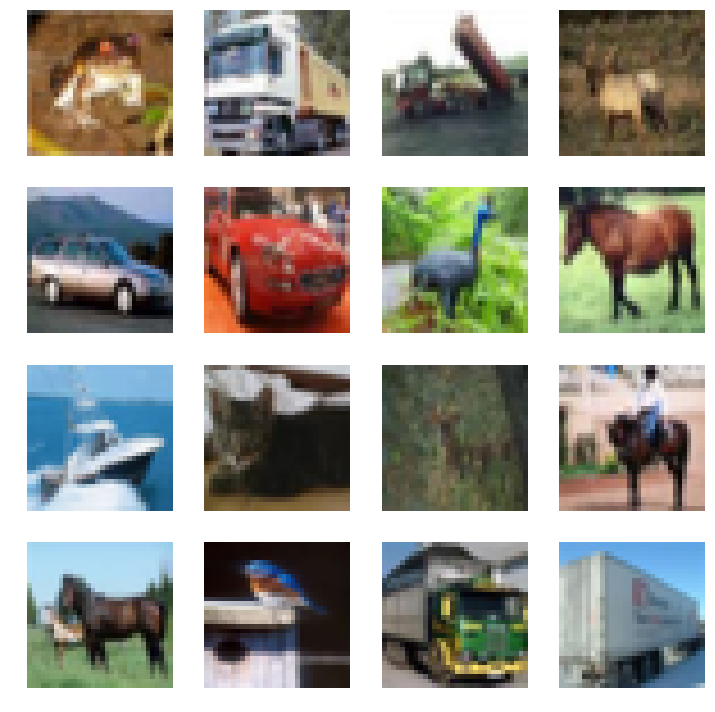

In [19]:
from matplotlib import pyplot as plt

def plot_images(images, labels=None, figsize=(10, 10), fname=None):
    """ Plot some images """
    n_examples = len(images)
    dim = np.ceil(np.sqrt(n_examples))
    plt.figure(figsize=figsize)
    class_names = ['airplane','automobile','bird','cat','deer', 'dog','frog','horse','ship','truck']
    for i, img in enumerate(images):
        plt.subplot(dim, dim, i + 1)
        if img.shape[-1] == 3:
            img = img.astype(np.uint8)
            plt.imshow(img)
            if labels is not None:
                plt.suptitle(class_names[i])
        else:
            img = np.squeeze(img)
            plt.imshow(img, cmap=plt.cm.Greys)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

(images, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
plot_images(images[:16])
x_train = 2 * (images / 255. - 0.5)


Now we can design our generator and discriminator network.
Let us begin with a straight forward implementation of the generator network, following the DCGAN guidelines.
As noise input we sample from a `latent_dim = 64` dimensional latent space.

In [20]:
layers = keras.layers

print('Generator')
latent_dim = 64
generator_input = layers.Input(shape=[latent_dim])
x = layers.Dense(2 * 2 * 512, activation='relu')(generator_input)
x = layers.Reshape([2, 2, 512])(x)
x = layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(64, (5, 5), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(3, (3, 3), padding='same', activation='tanh')(x)
generator = keras.models.Model(inputs=generator_input, outputs=x)
print(generator.summary())

Generator
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 2048)              133120    
_________________________________________________________________
reshape (Reshape)            (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 512)         6554112   
_________________________________________________________________
batch_normalization_v1 (Batc (None, 4, 4, 512)         2048      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         3277056   
____________________________________________________________

As we can see we build a generator with ~ 10 M parameters, which maps from the latent space `(64,)` to the data space `(32,32,3)`.
Using `tanh` as last activation is important, because we scaled the data from [-1,1].


In [29]:
print('Discriminator')
discriminator_input = layers.Input(shape=[32, 32, 3])
x = layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same')(discriminator_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2D(128, (4, 4), padding='same', strides=(2, 2))(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2D(256, (4, 4), padding='same', strides=(2, 2))(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2D(512, (4, 4), padding='same', strides=(2, 2))(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(2, activation='softmax', kernel_regularizer=keras.regularizers.l1_l2(0.0004))(x)
discriminator = keras.models.Model(inputs=discriminator_input, outputs=x)
print(discriminator.summary())


Discriminator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 64)        1792      
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 8, 8, 128)         131200    
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 4, 4, 256)         524544    
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 4, 4, 256)         0      

Furthermore, we created our discriminator which classifies the input images of shape `(32,32,3)` into `(2,)` classes (fake, real).

Now, we can compile our model by setting the optimizer and loss function.

In [30]:
d_opt = keras.optimizers.Adam(lr=2e-4, beta_1=0.5, decay=0.0005)
discriminator.compile(loss='binary_crossentropy', optimizer=d_opt, metrics=['accuracy'])


After creating our discriminator model, we have to build and compile the GAN framework by stacking  the discriminator on top of the generator.


In [35]:
print('\nGenerative Adversarial Network')
gan_input = layers.Input(shape=[latent_dim])
gan_output = discriminator(generator(gan_input))
GAN = keras.models.Model(gan_input, gan_output)
print(GAN.summary())



Generative Adversarial Network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 64)                0         
_________________________________________________________________
model (Model)                (None, 32, 32, 3)         11096771  
_________________________________________________________________
model_5 (Model)              (None, 2)                 2759298   
Total params: 13,856,069
Trainable params: 13,854,021
Non-trainable params: 2,048
_________________________________________________________________
None


After building the framework, we have to compile the framework.
But before we have to freeze the weights of the discriminator. (Remember that for training the generators we have to fix the discriminator,
we want to fool the discriminator by drawing nice images, not by making our discriminator a bad classifier).


In [36]:
def make_trainable(model, trainable):
    """ Function to freeze / unfreeze a model """
    model.trainable = trainable
    for l in model.layers:
        l.trainable = trainable

g_opt = keras.optimizers.Adam(lr=2e-4, beta_1=0.5, decay=0.0005)
make_trainable(discriminator, False)  # freezes the discriminator when training the GAN
GAN.compile(loss='binary_crossentropy', optimizer=g_opt)


Note that after we compiled a model, calling `make_trainable` will have no effect toll compiling the model again.

We now can design the training loop of the framework

In [ ]:
def train_gan(epochs=0, batch_size=64):
    for epoch in range(epochs):
    
        # Plot some fake images
        noise = np.random.randn(batch_size, latent_dim)
        generated_images = 255. * (generator.predict(noise) / 2. + 0.5)
        plot_images(generated_images[:16], fname=log_dir + '/generated_images_%.3i' % epoch)
    
        perm = np.random.choice(50000, size=50000, replace='False')
    
        for i in range(50000//batch_size):
    
            # Create a mini-batch of data (X: real images + fake images, y: corresponding class vectors)
            image_batch = x_train[perm[i*batch_size:(i+1)*batch_size], :, :, :]    # real images
            noise_gen = np.random.randn(batch_size, latent_dim)
            generated_images = generator.predict(noise_gen)                     # generated images
            X = np.concatenate((image_batch, generated_images))
            y = np.zeros([2*batch_size, 2])   # class vector
            y[0:batch_size, 1] = 1
            y[batch_size:, 0] = 1
    
            # Train the discriminator on the mini-batch
            d_loss, d_acc = discriminator.train_on_batch(X, y)
            losses["d"].append(d_loss)
            discriminator_acc.append(d_acc)
    
            # Create a mini-batch of data (X: noise, y: class vectors pretending that these produce real images)
            noise_tr = np.random.randn(batch_size, latent_dim)
            y2 = np.zeros([batch_size, 2])
            y2[:, 1] = 1

    
            # Train the generator on the mini-batch
            g_loss = GAN.train_on_batch(noise_tr, y2)
            losses["g"].append(g_loss)
            print(discriminator_acc[-1])


We now just could train our network by calling `train_gan(epochs=100)`.
But instead, let us load a pretrained model.

###### WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
-> This warning is harmless and just occured, because we compiled the discriminator and later froze its weights for the generator training.

In [ ]:
# load pretrained model here


### Results




### Problems training GANs
In general, training GANs is a very challenging task and needs a lot of fine tuning compared to supverised training of deep networks.
The reason for this is, that we do not have a stationary minimization problem any more, but a two networks playing a minmax game.
The updates of the the generator will highly affect the next step of the dicriminator update and the other way round.
Beside 
- Non-stationary minimization problem. Do not use optimizers with high momentum rates
- Mode collapsing
- Vanishing gradients
- Metric

#### Mode collapsing - "Helvetica Scenario"
After the training, the generator outputs samples from a restricted phase space only.
This is heavily connected to the control of the discriminator gradients. When the discriminator covers only a part of the modes in data,
the feedback will only be informative for this modes. This heavily drives the generator to collapse towards this mode,
which forces the discriminator to focus even more of this specific mode.

<img src="images/mnist_mode_collapse.png" alt="drawing" width="487"/>

To solve this one can try to use:
- Batch history (add in the persent batch of generated samples, samples generated by the model in earlier iterations)
- Add noise into the framework
- Conditioning of GANs - change to semi supverised training by adding label information to generator and/or discriminator
    - CGAN : Condition generator to produce specific sample, [Mirza, Osindero](https://arxiv.org/abs/1411.1784)
    - ACGAN: let the discriminator learn conditional probability, [Odena, Olah, Shlenset](https://arxiv.org/abs/1610.09585)
    
<img src="https://raw.githubusercontent.com/buriburisuri/ac-gan/master/png/architecture.png" alt="drawing" width="600"/>



#### Vanishing gradients
For training a reasonable generator, the feedback of the discriminator is crucial.
Therefore, one could think, that training the discrimnator more often than the generator could improve the training,
because the feedback would be much more precise.
The problem is, that for this scenario the feedback of the discriminator is almost zero.
When calculating the gradient for the generator update provided by a converged discriminator one obtains vanishing feedback:
 
$\lim_{D \rightarrow 0} \frac{\partial{}}{\partial{\theta}} \log(1-D(G_{\theta}(z))) = \lim_{f \rightarrow -\infty} \frac{\partial{}}{\partial{\theta}}\log\left( 1- \frac{1}{1+e^{-f_{\theta}}} \right) \approx 0$

Hence, having a strong discriminator will hinter the training.
In order to prevent that, we used regularization (dropout + l1 + l2)  in the discriminator.

#### Meaningless Loss Metric
By inspecting the loss of discriminator and generator, we can see that they do not correlate with the image quality.
(the discriminator is not trained to convergence). Hence, it is quiet hard to say if our framework reached a stable equilibrium.



## Wasserstein GANs
To overcome the issue of the meaningless metric and vanishing gradients.
[Arjovsky, Chintala and Bottou](https://arxiv.org/abs/1701.07875) proposed to used the Wasserstein-1 as metric.
Using the Wasserstein distance as metric has several advantages in comparison to the old minmax loss.
The crucial feature of the Wasserstein distance is that it provides a meaningful distance measure even to distributions are disjunct.
But before coming to the crucial difference let us try to understand the Wasserstein distance.

### Wasserstein or Earth Mover's distance
Wassertsein-1 or the earth mover's distancedescribes the *minimal cost* to transform a distribution $P_{\theta}$ into another disitribution $P_{r}$ and vice versa.
The mathematical defintion is as follows:
$\mathcal{D}_W(P_r|| P_\theta)= \inf_{\gamma \in \Pi(P_r, P_\theta)} \mathbb{E}_{(x,y) \sim \gamma}[||x-y||]$
The Wasserstein distance can be understand using a very figurative example.
Let us assume, we have two heaps of earth in the garden and would like to know, what is the minimum *work* we need to transform one heap of earth into the other one.
In other words, how many shovels of earth we have to transport which distance. (Work: mass * distance)
The optimal transport plan for this transformation, is given by the Wasserstein distance. 

<img src="images/earth_movers_distance.png" alt="drawing" width="600"/>

### Improved training of GANs
When interpreting the training of GANs as divergence minimization, the training of vanilla GANs is similar (assuming an optimal discriminator) to minimizing the *Jensen-Shannon divergence* (JS divergence).
The JS divergence do not provied a meaningful distance measure for disjoint distributions (no overlap).
In contrast, the Wasserstein distance does (in the figurative example both heaps of earth are disjoint)
Especially in the beginning of the training, both distributions are disjoint. Because the discriminator can very easily discriminate perfectly between real and fake images.
Furthermore, because of the easy formulation of the distance measure (mass * distance) we can expect smooth gradients. 

### Approximation of the Wasserstein distance using a critic
Using the Kantorovich-Rubinstein duality we are able to construct the Wasserstein distance ourselves and the loss becomes:

$\mathcal{L_{WGAN}} = \min_{ D_w \in Lip_1} \mathbb{E}_{x \sim P_r}[D_w(x)] - \mathbb{E}_{\tilde{x} \sim P_\theta}{[D_w(\tilde{x})]}$,

where $D_w(x)$ is the discriminator network (in the WGAN setup called *critic* because the network is not trained to discriminate anymore).
Basically the distance/loss $\mathcal{L_{WGAN}}$ is formed, by subtracting the output of the critic applied on the fake samples from the critic applied on the real samples. 
It is important, that  $D \in Lip_1$ denotes, that the function the critic network should approximate is a 1-Lipschitz function.
A 1-Lipschitz function is a function, which has a slope $m\ leq 1$ everywhere.
Therefore, the critic network has to carry this Lipschitz constrain<sup>[4](#myfootnote1)</sup> also.
The are 2 possible constraints to construct the Wasserstein distance:
- Use weight clipping, which is less preferred<sup>[5](#myfootnote1)</sup>
- Gradient penalty

[Gulrajani et. al.](https://arxiv.org/abs/1704.00028) proposed the **Gradient penalty** to construct the Lipschitz constrain by extending the loss $\mathcal{L_{WGAN}}$ with:

$\mathcal{L}_{GP} = \lambda\; \mathbb{E}_{\hat{u} \sim P_{\hat{u}}}[(||\nabla_{\hat{u}}D_w(\hat{u})||_2-1)^2]$,

where $\lambda$ is a hyperparameter to scale the loss and $\hat{u}=\epsilon x + (1-\epsilon)\tilde{x}\;,0 \leq \epsilon \leq 1$ is randomly sampled along straight lines between pairs of data and fake samples, with
In simple words, the gradient in the discriminator is forced to have norm $1$ everywhere between the distribution of real and fake samples.
Implementing this "objective" makes explicitly clear, that the WGAN will not suffer from vanishing gradients.

--- Footnotes
<a name="myfootnote1">4</a>: Easy interpretation: We need a constraint to train the discriminator to convergence, otherwise the discriminator could focus on one feature which differs between real and fake samples and won't converge


<a name="myfootnote2">5</a>: Weight clamping will heavily reduce the capacity of the discriminator which is unfavourable.


<a name="myfootnote3">6</a>: Using ReLU in the discriminator woul lead to sparase gradient (no negative gradient could propagate back).
Using LeakyReLU provides better feedback.


### Implementation of improved Wasserstein GAN - WGAN-GP
After the short introduction into WGANs, let us try to implement our first own WGAN using tf.contrib.GAN.


In [14]:
import tensorflow as tf
import numpy as np
from plotting import plot_images
layers = tf.layers
print("TensorFlow version", tf.__version__)


('TensorFlow version', '1.13.1')


Let us start to build a data pipeline.
First we need to define our Data generator.
The generator should output real samples (input for the discriminator) and noise (input for the generator)
The variable LATENT_DIM defines the dimensionality of the latent space of the generator.
(The noise distribution we sample from).

In [15]:
def generator(LATENT_DIM):
    while True:
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
        labels = tf.keras.utils.to_categorical(y_train)
        nsamples = x_train.shape[0]
        images = 2 * (x_train / 255. - 0.5)
        images = images.astype(np.float32)
        noise = np.random.randn(nsamples, LATENT_DIM).reshape(nsamples, LATENT_DIM)
        idx = np.random.permutation(nsamples)
        noise = noise[idx]
        images = images[idx]
        labels = labels[idx]
        for i in range(nsamples):
            yield ((noise[i], labels[i]), (images[i]))

Let us now check if our generator is working

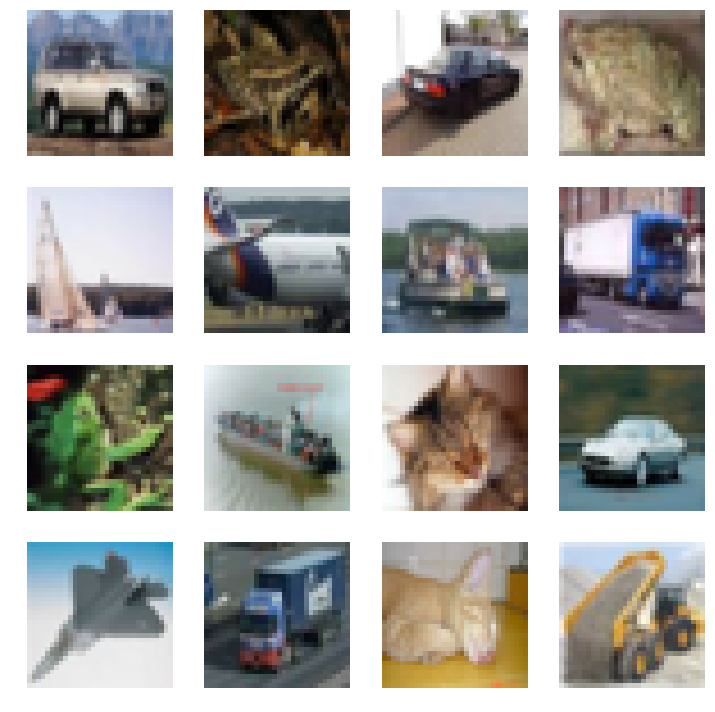

In [16]:
import itertools
generator_output = np.array(list(itertools.islice(generator(64), 16)))
test_images = 255. * (generator_output[:,1] / 2. + 0.5)
plot_images(test_images[:16])

To train our estimator we can make create a TensorflowDataset out of our data generator.
The function outputs a batches of our dataset.

In [7]:
def batched_dataset(BATCH_SIZE, LATENT_DIM, generator_fn):
    Dataset = tf.data.Dataset.from_generator(
        lambda: generator_fn(LATENT_DIM), output_types=((tf.float32, tf.float32), (tf.float32)),
        output_shapes=((tf.TensorShape((LATENT_DIM,)), tf.TensorShape((10,))), (tf.TensorShape((32, 32, 3)))))
    return Dataset.batch(BATCH_SIZE)

For training GANs we need to further define our generator and discriminator network.
We start by defining our generator network, which should map from our noise space into the space of out images (LATENT_DIM --> IMAGE_DIM)

In [15]:
def generator_fn(inputs, latent_dim=LATENT_DIM):
    x, labels = inputs
    x = tf.concat([x, labels], axis=-1)
    print("x after concat", x)
    x = layers.Dense(4 * 4 * 256, activation='relu', input_shape=(latent_dim + 10,))(x)  #
    x = tf.reshape(x, shape=[BATCH_SIZE, 4, 4, 256])
    x = layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(3, (3, 3), padding='same', activation='tanh')(x)
    return x

After defining our generator network we need now to implement our discriminator.
The task of the discriminator is to measure the similarity between the fake images (output of the generator) and the real images.
So, the network maps from the image space into a 1D space where we can measure the 'distance' between the distributions of the real and generated images.  (IMAGE_DIM --> 1)

In [9]:
def discriminator_fn(x, gen_in, drop_rate=0.25):
    """ Discriminator network """
    print("dis_in, x", x)
    noise, labels = gen_in
    print(noise.shape, labels.shape)
    x = layers.Conv2D(64, (3, 3), padding='same', input_shape=(32, 32, 3))(x)
    x = tf.contrib.layers.layer_norm(x)
    x = tf.nn.leaky_relu(x, 0.2)
    x = layers.Conv2D(64, (4, 4), padding='same', strides=(2, 2))(x)
    x = tf.contrib.layers.layer_norm(x)
    x = tf.nn.leaky_relu(x, 0.2)
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = tf.contrib.layers.layer_norm(x)
    x = tf.nn.leaky_relu(x, 0.2)
    x = layers.Conv2D(128, (4, 4), padding='same', strides=(2, 2))(x)
    x = tf.contrib.layers.layer_norm(x)
    x = tf.nn.leaky_relu(x, 0.2)
    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = tf.contrib.layers.layer_norm(x)
    x = tf.nn.leaky_relu(x, 0.2)
    x = layers.Conv2D(256, (4, 4), padding='same', strides=(2, 2))(x)
    x = tf.contrib.layers.layer_norm(x)
    x = tf.nn.leaky_relu(x, 0.2)
    x = layers.Conv2D(512, (3, 3), padding='same')(x)
    x = tf.nn.leaky_relu(x, 0.2)
    x = layers.Flatten()(x)
    labels = layers.Dense(50)(labels)
    labels = tf.nn.leaky_relu(labels, 0.2)
    x = tf.concat([x, labels], axis=-1)
    x = layers.Dense(200)(x)
    x = tf.nn.leaky_relu(x, 0.2)
    x = layers.Dense(1)(x)
    return x


So let use use the [Gradient Penalty](https://arxiv.org/abs/1704.00028):
By penalizing the gradient to be smaller than 1, we enforce the lipschitz constraint needed to construct Wasserstein using the Kantorovich-Rubinstein duality(https://cedricvillani.org/wp-content/uploads/2012/08/preprint-1.pdf)
GP is the hyperparameter to weight the strength of the Lipschitz constrain.
We can make use of the preliminary implemented wasserstein_loss which evaluates $\mathcal{L_{WGAN}}$, **without** enforcing a Lipschitz connstrain.

In [10]:
def discrimintator_loss(model, add_summaries=True):

    loss = tf.contrib.gan.losses.wasserstein_discriminator_loss(model, add_summaries=add_summaries)
    gp_loss = GP * tf.contrib.gan.losses.wasserstein_gradient_penalty(model, epsilon=1e-10, one_sided=True, add_summaries=add_summaries)
    loss += gp_loss

    if add_summaries:
        tf.summary.scalar('discriminator_loss', loss)

    return loss

After defining our loss we can choose our training parameters

In [11]:
BATCH_SIZE = 32  # number of samples fed into the framework in each iteration
LATENT_DIM = 64  # dimension of the generators latent space
GEN_LR = 0.0002   # learning rate of the generator
DIS_LR = 0.0002  # learning rate of the discriminator
ITER = 1000      # framework iterations
LOG_DIR = "models/WGAN_GP/"    # directory of the estimator (to save the graph and checkpoints)
dir = tutorial.make_dir(LOG_DIR, "WGAN_GP")
GP = 10          # factor to scale the gradient penalty (higher means larger enforcing the Lipschitz constrain)
N_CRIT = 5       # number of critic iterations per generator iterations.

Now we can very easily implement our framework as estimator using tfgan, this will heavily simplify our training procedure.

In [16]:
tfgan = tf.contrib.gan
gan_estimator = tfgan.estimator.GANEstimator(
    dir,
    generator_fn=generator_fn,
    discriminator_fn=discriminator_fn,
    generator_loss_fn=tfgan.losses.wasserstein_generator_loss,
    discriminator_loss_fn=discrimintator_loss,
    generator_optimizer=tf.train.AdamOptimizer(GEN_LR, 0.5),
    discriminator_optimizer=tf.train.AdamOptimizer(DIS_LR, 0.5),
    get_hooks_fn=tfgan.get_sequential_train_hooks(tfgan.GANTrainSteps(1, N_CRIT)),
    config=tf.estimator.RunConfig(save_summary_steps=10, keep_checkpoint_max=1, save_checkpoints_steps=200),
    use_loss_summaries=True)

INFO:tensorflow:Using config: {'_save_checkpoints_secs': None, '_num_ps_replicas': 0, '_keep_checkpoint_max': 1, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7feb89959890>, '_model_dir': './WGAN_GP_train_2019-04-04_17:03:06', '_protocol': None, '_save_checkpoints_steps': 200, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_tf_random_seed': None, '_save_summary_steps': 10, '_device_fn': None, '_experimental_distribute': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_train_distribute': None, '_master': ''}


Let us train our framework using our gan_estimator and our data_pipeline.

*We skip the training here and import a pretrained estimator*

In [21]:
gan_estimator.train(lambda: batch_dataset(BATCH_SIZE, LATENT_DIM, generator), maxsteps=1000)

INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ./WGAN_GP_train_2019-04-04_17:03:06/model.ckpt.
INFO:tensorflow:loss = 0.041437, step = 1
INFO:tensorflow:global_step/sec: 0.434456
INFO:tensorflow:loss = -5.485588, step = 101 (230.182 sec)
INFO:tensorflow:Saving checkpoints for 200 into ./WGAN_GP_train_2019-04-04_17:03:06/model.ckpt.
Instructions for updating:
Use standard file APIs to delete files with this prefix.
INFO:tensorflow:global_step/sec: 0.427456
INFO:tensorflow:loss = 1.0505079, step = 201 (233.934 sec)
INFO:tensorflow:global_step/sec: 0.388586
INFO:tensorflow:loss = 0.48207843, step = 301 (257.343 sec)
INFO:tensorflow:Saving checkpoints for 400 into

### Results


After dealing with the CIFAR dataset let us tackle a physics dataset
## Spectral Normalization GANs

### Gradient Penalty in terms of normalization 


### Spectral Norm



## Calorimeter images
### Spectral Normalization of generator


###


